# 05 - Feature Selection

This notebook handles feature selection for the autoscaling prediction models:

1. **Hypothesis Testing** - Statistical tests for patterns
2. **Feature Importance** - Random Forest & mutual information
3. **Correlation Filtering** - Remove highly correlated features
4. **Final Feature Set** - Selected features for modeling

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json

# ML imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"

# Load data
df = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")

# Load feature info
with open(PROCESSED_DIR / "feature_info.json", 'r') as f:
    feature_info = json.load(f)

print(f"Train shape: {df.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nFeature categories: {list(feature_info['feature_categories'].keys())}")

Train shape: (15264, 98)
Test shape: (2592, 98)

Feature categories: ['time', 'lag', 'rolling', 'advanced', 'aggregation']


In [3]:
# Define target and features
TARGET = 'request_count'

# Get numeric features only (exclude timestamp and categorical)
exclude_cols = ['timestamp', 'time_of_day', 'part_of_day', TARGET]
numeric_features = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]

print(f"Target: {TARGET}")
print(f"Numeric features: {len(numeric_features)}")

Target: request_count
Numeric features: 92


## 2. Hypothesis Testing

### 2.1 Weekend Effect

**H0**: Traffic on weekends is the same as weekdays  
**H1**: Traffic on weekends is significantly lower than weekdays

In [4]:
# Weekend vs Weekday t-test
weekday_traffic = df[df['is_weekend'] == 0][TARGET]
weekend_traffic = df[df['is_weekend'] == 1][TARGET]

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(weekday_traffic, weekend_traffic, alternative='greater')

print("=== WEEKEND EFFECT TEST ===")
print(f"\nWeekday mean: {weekday_traffic.mean():.2f} requests/5min")
print(f"Weekend mean: {weekend_traffic.mean():.2f} requests/5min")
print(f"Difference: {weekday_traffic.mean() - weekend_traffic.mean():.2f} requests/5min")
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"\nConclusion: {'REJECT H0 - Weekend traffic is significantly lower' if p_value < 0.05 else 'FAIL TO REJECT H0'}")

# Effect size (Cohen's d)
cohens_d = (weekday_traffic.mean() - weekend_traffic.mean()) / np.sqrt(
    ((len(weekday_traffic)-1)*weekday_traffic.var() + (len(weekend_traffic)-1)*weekend_traffic.var()) / 
    (len(weekday_traffic) + len(weekend_traffic) - 2)
)
print(f"Effect size (Cohen's d): {cohens_d:.3f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'})")

=== WEEKEND EFFECT TEST ===

Weekday mean: 221.44 requests/5min
Weekend mean: 123.63 requests/5min
Difference: 97.81 requests/5min

t-statistic: 40.9776
p-value: 0.00e+00

Conclusion: REJECT H0 - Weekend traffic is significantly lower
Effect size (Cohen's d): 0.722 (medium)


### 2.2 Business Hours Effect

**H0**: Traffic during business hours is the same as non-business hours  
**H1**: Traffic during business hours is significantly higher

In [5]:
# Business hours vs non-business hours t-test
business_traffic = df[df['is_business_hour'] == 1][TARGET]
non_business_traffic = df[df['is_business_hour'] == 0][TARGET]

t_stat, p_value = stats.ttest_ind(business_traffic, non_business_traffic, alternative='greater')

print("=== BUSINESS HOURS EFFECT TEST ===")
print(f"\nBusiness hours mean: {business_traffic.mean():.2f} requests/5min")
print(f"Non-business mean: {non_business_traffic.mean():.2f} requests/5min")
print(f"Difference: {business_traffic.mean() - non_business_traffic.mean():.2f} requests/5min")
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"\nConclusion: {'REJECT H0 - Business hours have significantly higher traffic' if p_value < 0.05 else 'FAIL TO REJECT H0'}")

=== BUSINESS HOURS EFFECT TEST ===

Business hours mean: 270.77 requests/5min
Non-business mean: 135.59 requests/5min
Difference: 135.17 requests/5min

t-statistic: 65.2905
p-value: 0.00e+00

Conclusion: REJECT H0 - Business hours have significantly higher traffic


### 2.3 Hourly ANOVA

**H0**: Traffic is the same across all hours  
**H1**: Traffic differs significantly between hours

In [6]:
# One-way ANOVA across hours
hourly_groups = [df[df['hour'] == h][TARGET].values for h in range(24)]

f_stat, p_value = stats.f_oneway(*hourly_groups)

print("=== HOURLY ANOVA TEST ===")
print(f"\nF-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"\nConclusion: {'REJECT H0 - Traffic differs significantly between hours' if p_value < 0.05 else 'FAIL TO REJECT H0'}")

# Post-hoc: Which hours are significantly different?
hourly_means = df.groupby('hour')[TARGET].mean()
overall_mean = df[TARGET].mean()

print(f"\nHours with traffic > average ({overall_mean:.0f}):")
high_hours = hourly_means[hourly_means > overall_mean].sort_values(ascending=False)
for hour, mean in high_hours.items():
    print(f"  Hour {hour:02d}: {mean:.0f} (+{mean - overall_mean:.0f})")

=== HOURLY ANOVA TEST ===

F-statistic: 268.6685
p-value: 0.00e+00

Conclusion: REJECT H0 - Traffic differs significantly between hours

Hours with traffic > average (192):
  Hour 15: 303 (+112)
  Hour 12: 303 (+111)
  Hour 13: 300 (+108)
  Hour 14: 300 (+108)
  Hour 16: 291 (+99)
  Hour 11: 280 (+88)
  Hour 10: 256 (+64)
  Hour 17: 239 (+47)
  Hour 09: 238 (+46)
  Hour 08: 197 (+5)
  Hour 18: 195 (+4)


### 2.4 Weekly Seasonality Test (Kruskal-Wallis)

Non-parametric test for day-of-week effect

In [7]:
# Kruskal-Wallis test for day of week
dow_groups = [df[df['day_of_week'] == d][TARGET].values for d in range(7)]

h_stat, p_value = stats.kruskal(*dow_groups)

dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print("=== DAY OF WEEK KRUSKAL-WALLIS TEST ===")
print(f"\nH-statistic: {h_stat:.4f}")
print(f"p-value: {p_value:.2e}")
print(f"\nConclusion: {'REJECT H0 - Traffic differs significantly between days' if p_value < 0.05 else 'FAIL TO REJECT H0'}")

# Show means by day
print("\nMean traffic by day:")
for d, name in enumerate(dow_names):
    mean = df[df['day_of_week'] == d][TARGET].mean()
    print(f"  {name}: {mean:.0f}")

=== DAY OF WEEK KRUSKAL-WALLIS TEST ===

H-statistic: 1606.2763
p-value: 0.00e+00

Conclusion: REJECT H0 - Traffic differs significantly between days

Mean traffic by day:
  Monday: 206
  Tuesday: 212
  Wednesday: 216
  Thursday: 260
  Friday: 218
  Saturday: 124
  Sunday: 123


### 2.5 Stationarity Test (ADF)

In [8]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
result = adfuller(df[TARGET].dropna(), autolag='AIC')

print("=== STATIONARITY TEST (ADF) ===")
print(f"\nADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.4f}")

if result[1] < 0.05:
    print(f"\nConclusion: REJECT H0 - Series is STATIONARY")
else:
    print(f"\nConclusion: FAIL TO REJECT H0 - Series is NON-STATIONARY (may need differencing)")

=== STATIONARITY TEST (ADF) ===

ADF Statistic: -9.5091
p-value: 0.0000
Critical Values:
  1%: -3.4308
  5%: -2.8617
  10%: -2.5669

Conclusion: REJECT H0 - Series is STATIONARY


## 3. Feature Importance Analysis

### 3.1 Random Forest Feature Importance

In [9]:
# Prepare data
X = df[numeric_features].copy()
y = df[TARGET].copy()

# Handle infinity values (replace with NaN first)
X = X.replace([np.inf, -np.inf], np.nan)

# Handle any remaining NaN - use median for robustness
X = X.fillna(X.median())

# Verify no remaining issues
print(f"Checking data quality:")
print(f"  NaN count: {X.isna().sum().sum()}")
print(f"  Inf count: {np.isinf(X.values).sum()}")

# Train Random Forest
print("\nTraining Random Forest for feature importance...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTraining R2 score: {rf.score(X, y):.4f}")
print(f"\nTop 20 features by Random Forest importance:")
print(rf_importance.head(20).to_string(index=False))

Checking data quality:
  NaN count: 0
  Inf count: 0

Training Random Forest for feature importance...

Training R2 score: 1.0000

Top 20 features by Random Forest importance:
                       feature  importance
      request_count_pct_of_max    0.997013
         request_count_diff_60    0.001005
    request_count_vs_yesterday    0.000852
        request_count_diff_288    0.000596
  request_count_rolling_mean_3    0.000198
                  unique_hosts    0.000056
                       mod_sin    0.000038
   request_count_rolling_max_3    0.000034
      request_count_ewm_mean_5    0.000029
             bytes_total_lag_3    0.000014
       request_count_ewm_std_5    0.000009
                   bytes_total    0.000008
         request_count_diff_12    0.000007
        request_count_momentum    0.000006
 request_count_rolling_mean_60    0.000006
        request_count_bb_upper    0.000006
          request_count_diff_6    0.000005
  request_count_rolling_std_12    0.000005
       

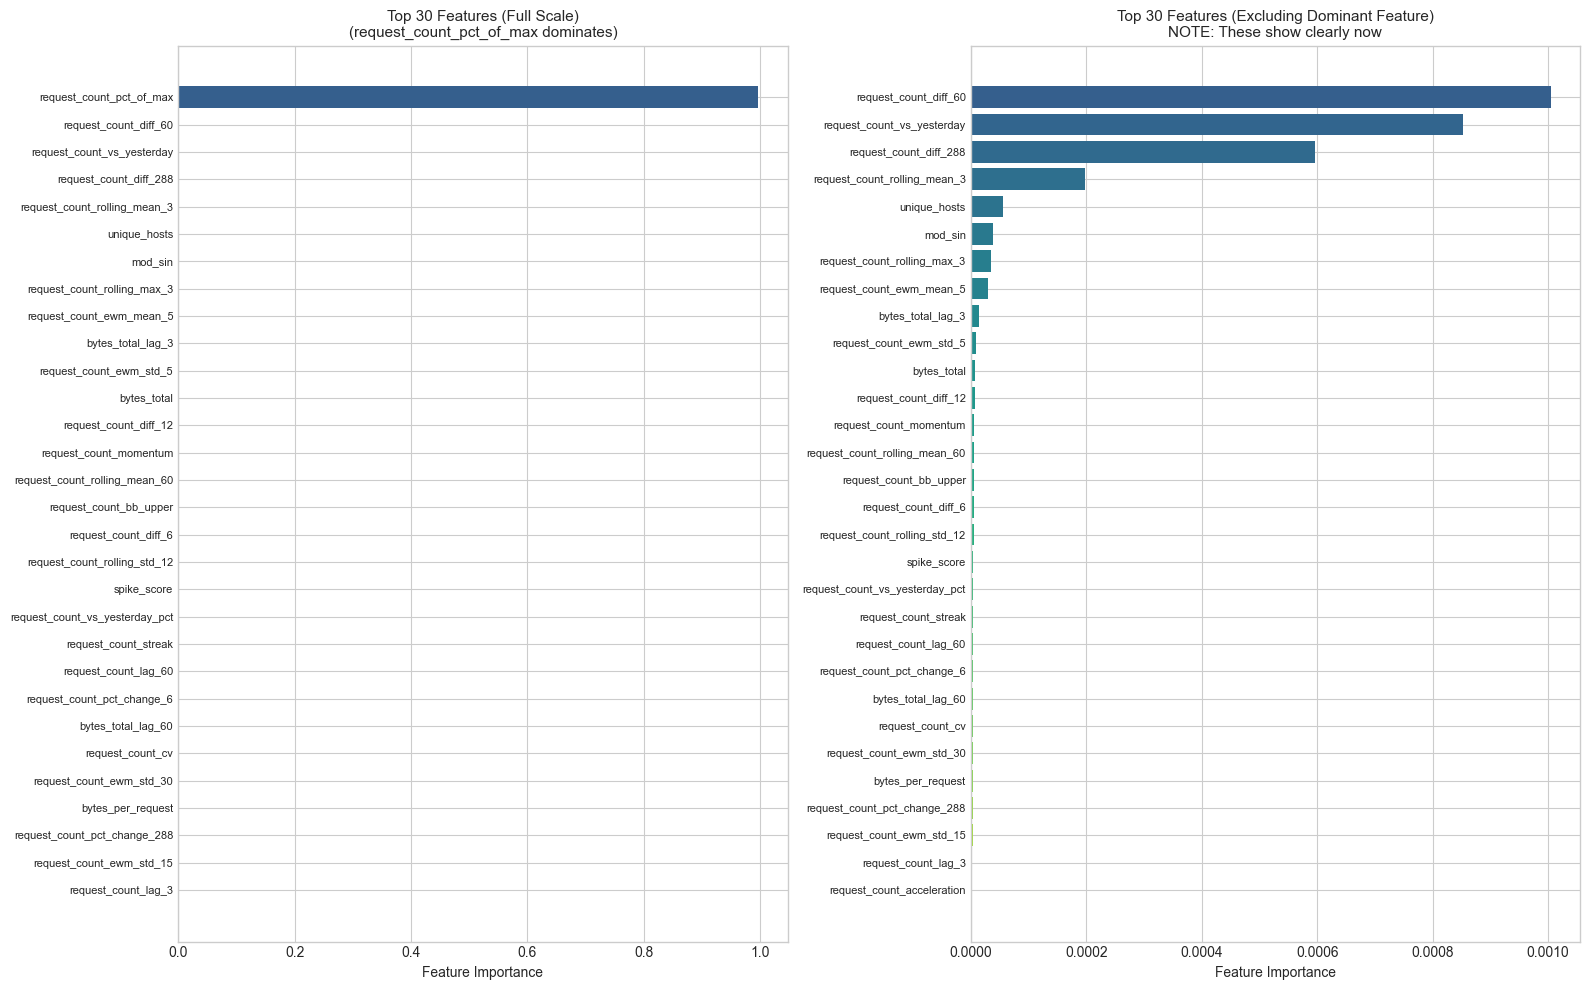

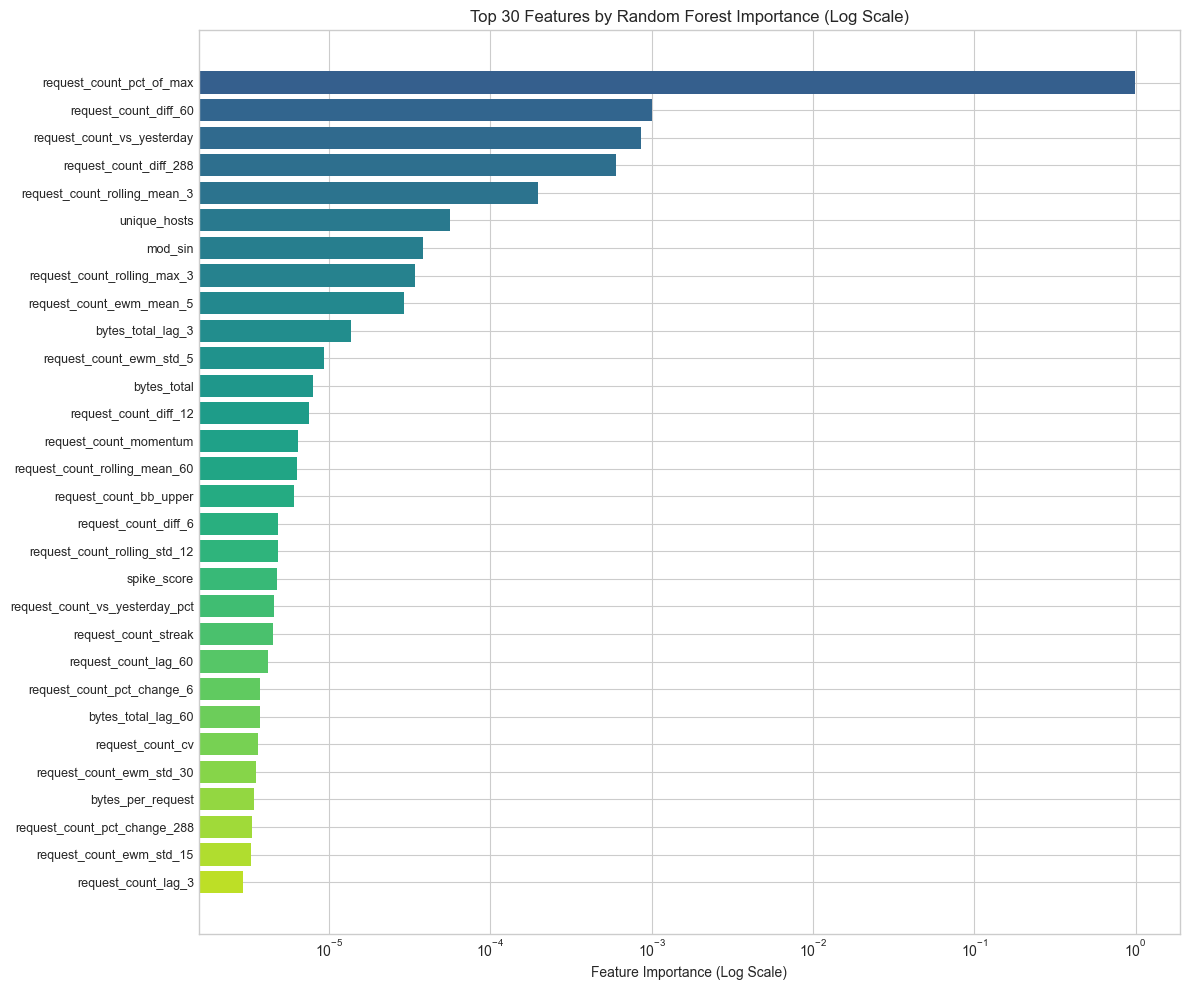


NOTE: request_count_pct_of_max has extremely high importance (0.996)
This may indicate DATA LEAKAGE - this feature is computed from the target!
Consider removing this feature for fair model evaluation.


In [10]:
# Visualize top 30 features (with fix for dominant feature)
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

top30 = rf_importance.head(30)

# Plot 1: Full view (shows how dominant request_count_pct_of_max is)
ax = axes[0]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top30)))
ax.barh(range(len(top30)), top30['importance'], color=colors)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['feature'], fontsize=8)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Features (Full Scale)\n(request_count_pct_of_max dominates)', fontsize=11)
ax.invert_yaxis()

# Plot 2: Excluding top feature to see others clearly
ax = axes[1]
top30_excl = rf_importance.iloc[1:31]  # Skip the first (dominant) feature
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top30_excl)))
ax.barh(range(len(top30_excl)), top30_excl['importance'], color=colors)
ax.set_yticks(range(len(top30_excl)))
ax.set_yticklabels(top30_excl['feature'], fontsize=8)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Features (Excluding Dominant Feature)\nNOTE: These show clearly now', fontsize=11)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Also show as log scale
fig, ax = plt.subplots(figsize=(12, 10))
top30 = rf_importance.head(30)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top30)))
ax.barh(range(len(top30)), top30['importance'], color=colors)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['feature'], fontsize=9)
ax.set_xlabel('Feature Importance (Log Scale)')
ax.set_title('Top 30 Features by Random Forest Importance (Log Scale)', fontsize=12)
ax.set_xscale('log')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nNOTE: request_count_pct_of_max has extremely high importance (0.996)")
print("This may indicate DATA LEAKAGE - this feature is computed from the target!")
print("Consider removing this feature for fair model evaluation.")

### 3.2 Mutual Information

In [11]:
# Compute mutual information
print("Computing mutual information scores...")
mi_scores = mutual_info_regression(X, y, random_state=42)

mi_importance = pd.DataFrame({
    'feature': numeric_features,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print(f"\nTop 20 features by Mutual Information:")
print(mi_importance.head(20).to_string(index=False))

Computing mutual information scores...

Top 20 features by Mutual Information:
                      feature  mi_score
     request_count_pct_of_max  5.824704
  request_count_rolling_max_3  2.475208
  request_count_rolling_min_3  2.398947
            requests_per_host  1.951758
                   error_rate  1.828775
     request_count_ewm_mean_5  1.524951
                 unique_hosts  1.502971
 request_count_rolling_mean_3  1.461390
 request_count_rolling_max_12  1.395507
                 success_rate  1.381583
 request_count_rolling_min_12  1.278690
    request_count_ewm_mean_15  1.196274
request_count_rolling_mean_12  1.158223
       request_count_bb_upper  1.112090
          request_count_lag_1  1.055024
    request_count_ewm_mean_30  0.999509
       request_count_bb_lower  0.979220
                  bytes_total  0.943116
          request_count_lag_3  0.909763
          request_count_lag_6  0.849476


### 3.3 F-Regression Scores

In [12]:
# F-regression scores
f_scores, p_values = f_regression(X, y)

f_importance = pd.DataFrame({
    'feature': numeric_features,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print(f"\nTop 20 features by F-score:")
print(f_importance.head(20).to_string(index=False))


Top 20 features by F-score:
                      feature      f_score  p_value
     request_count_pct_of_max 1.321806e+18      0.0
     request_count_ewm_mean_5 2.653533e+05      0.0
 request_count_rolling_mean_3 2.311203e+05      0.0
                 unique_hosts 2.067905e+05      0.0
  request_count_rolling_max_3 1.762041e+05      0.0
  request_count_rolling_min_3 1.530062e+05      0.0
    request_count_ewm_mean_15 1.204702e+05      0.0
request_count_rolling_mean_12 1.074671e+05      0.0
 request_count_rolling_max_12 8.967161e+04      0.0
          request_count_lag_1 8.733277e+04      0.0
       request_count_bb_upper 7.660266e+04      0.0
    request_count_ewm_mean_30 7.253741e+04      0.0
          request_count_lag_3 5.751940e+04      0.0
 request_count_rolling_min_12 5.264504e+04      0.0
                  bytes_total 5.182001e+04      0.0
          request_count_lag_6 4.794328e+04      0.0
       request_count_bb_lower 4.727297e+04      0.0
         request_count_lag_12 3.553

### 3.4 Combined Importance Ranking

In [13]:
# Combine rankings
combined = rf_importance.copy()
combined = combined.merge(mi_importance, on='feature')
combined = combined.merge(f_importance[['feature', 'f_score']], on='feature')

# Normalize scores to 0-1
for col in ['importance', 'mi_score', 'f_score']:
    combined[f'{col}_norm'] = (combined[col] - combined[col].min()) / (combined[col].max() - combined[col].min())

# Combined score (average of normalized scores)
combined['combined_score'] = (combined['importance_norm'] + combined['mi_score_norm'] + combined['f_score_norm']) / 3
combined = combined.sort_values('combined_score', ascending=False)

print("Top 25 features by combined importance:")
print(combined[['feature', 'importance', 'mi_score', 'f_score', 'combined_score']].head(25).to_string(index=False))

Top 25 features by combined importance:
                      feature   importance  mi_score      f_score  combined_score
     request_count_pct_of_max 9.970126e-01  5.824704 1.321806e+18        1.000000
  request_count_rolling_max_3 3.425894e-05  2.475208 1.762041e+05        0.141661
  request_count_rolling_min_3 1.606068e-06  2.398947 1.530062e+05        0.137286
            requests_per_host 8.810509e-07  1.951758 5.352802e+03        0.111695
                   error_rate 2.290227e-06  1.828775 9.076800e+00        0.104657
     request_count_ewm_mean_5 2.923161e-05  1.524951 2.653533e+05        0.087279
                 unique_hosts 5.628519e-05  1.502971 2.067905e+05        0.086030
 request_count_rolling_mean_3 1.981181e-04  1.461390 2.311203e+05        0.083698
 request_count_rolling_max_12 1.755898e-06  1.395507 8.967161e+04        0.079862
                 success_rate 1.675799e-06  1.381583 3.287650e+03        0.079065
 request_count_rolling_min_12 2.019088e-06  1.278690 5.264

## 4. Correlation Filtering

In [14]:
# Compute correlation matrix
corr_matrix = X.corr().abs()

# Get upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find highly correlated pairs (> 0.95)
high_corr_pairs = []
for col in upper.columns:
    for idx in upper.index:
        if upper.loc[idx, col] > 0.95:
            high_corr_pairs.append((idx, col, upper.loc[idx, col]))

print(f"Highly correlated pairs (> 0.95): {len(high_corr_pairs)}")
for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -x[2])[:20]:
    print(f"  {f1} <-> {f2}: {corr:.3f}")

Highly correlated pairs (> 0.95): 58
  bytes_avg <-> bytes_per_request: 1.000
  request_count_diff_288 <-> request_count_vs_yesterday: 1.000
  request_count_pct_change_288 <-> request_count_vs_yesterday_pct: 1.000
  request_count_diff_1 <-> request_count_velocity: 1.000
  month_sin <-> month_cos: 1.000
  month <-> month_sin: 1.000
  month <-> month_cos: 1.000
  request_count_rolling_mean_12 <-> request_count_ewm_mean_15: 0.997
  request_count_rolling_mean_3 <-> request_count_ewm_mean_5: 0.996
  day_of_year <-> week_of_year: 0.991
  hour_cos <-> mod_cos: 0.990
  hour_sin <-> mod_sin: 0.990
  request_count_rolling_mean_3 <-> request_count_rolling_max_3: 0.990
  request_count_ewm_mean_15 <-> request_count_ewm_mean_30: 0.989
  request_count_rolling_max_12 <-> request_count_bb_upper: 0.989
  request_count_rolling_max_3 <-> request_count_ewm_mean_5: 0.988
  request_count_ewm_mean_5 <-> request_count_ewm_mean_15: 0.987
  request_count_rolling_mean_12 <-> request_count_ewm_mean_5: 0.984
  requ

In [15]:
# Remove highly correlated features (keep the one with higher importance)
importance_dict = dict(zip(combined['feature'], combined['combined_score']))

features_to_drop = set()
for f1, f2, corr in high_corr_pairs:
    if corr > 0.95:
        # Drop the one with lower importance
        imp1 = importance_dict.get(f1, 0)
        imp2 = importance_dict.get(f2, 0)
        to_drop = f1 if imp1 < imp2 else f2
        features_to_drop.add(to_drop)

print(f"\nFeatures to drop due to high correlation: {len(features_to_drop)}")
print(f"Examples: {list(features_to_drop)[:10]}...")


Features to drop due to high correlation: 27
Examples: ['request_count_rolling_min_3', 'request_count_velocity', 'request_count_rolling_mean_3', 'request_count_rolling_std_12', 'request_count_bb_upper', 'request_count_ewm_mean_30', 'request_count_rolling_mean_60', 'month_sin', 'hour_cos', 'hour_sin']...


## 5. Final Feature Selection

In [16]:
# Select top features after removing highly correlated ones
filtered_features = combined[~combined['feature'].isin(features_to_drop)].copy()

# Select top N features
TOP_N = 40
selected_features = filtered_features.head(TOP_N)['feature'].tolist()

print(f"Selected {len(selected_features)} features for modeling:")
for i, feat in enumerate(selected_features, 1):
    imp = filtered_features[filtered_features['feature'] == feat]['combined_score'].values[0]
    print(f"  {i:2d}. {feat}: {imp:.4f}")

Selected 40 features for modeling:
   1. request_count_pct_of_max: 1.0000
   2. requests_per_host: 0.1117
   3. error_rate: 0.1047
   4. success_rate: 0.0791
   5. request_count_rolling_min_12: 0.0732
   6. bytes_total: 0.0540
   7. request_count_lag_3: 0.0521
   8. request_count_lag_12: 0.0443
   9. bytes_total_lag_1: 0.0440
  10. request_count_ewm_std_15: 0.0410
  11. bytes_total_lag_3: 0.0399
  12. bytes_total_lag_6: 0.0370
  13. request_count_rolling_std_60: 0.0363
  14. anomaly_score_ml: 0.0362
  15. request_count_diff_60: 0.0345
  16. bytes_total_lag_12: 0.0339
  17. request_count_pct_change_60: 0.0327
  18. request_count_ewm_std_5: 0.0324
  19. request_count_cv: 0.0315
  20. day_of_year: 0.0286
  21. request_count_diff_288: 0.0256
  22. bytes_max: 0.0256
  23. request_count_pct_change_12: 0.0250
  24. request_count_pct_change_3: 0.0246
  25. request_count_pct_change_6: 0.0245
  26. request_count_pct_change_288: 0.0242
  27. request_count_pct_change_1: 0.0242
  28. request_count_

In [17]:
# Categorize selected features
selected_categories = {
    'time': [],
    'lag': [],
    'rolling': [],
    'advanced': [],
    'aggregation': [],
    'other': []
}

for feat in selected_features:
    categorized = False
    for cat, cat_features in feature_info['feature_categories'].items():
        if feat in cat_features:
            selected_categories[cat].append(feat)
            categorized = True
            break
    if not categorized:
        selected_categories['other'].append(feat)

print("\nSelected features by category:")
for cat, feats in selected_categories.items():
    if feats:
        print(f"\n{cat.upper()} ({len(feats)} features):")
        for f in feats:
            print(f"  - {f}")


Selected features by category:

TIME (3 features):
  - day_of_year
  - hour
  - day

LAG (19 features):
  - request_count_lag_3
  - request_count_lag_12
  - bytes_total_lag_1
  - bytes_total_lag_3
  - bytes_total_lag_6
  - request_count_diff_60
  - bytes_total_lag_12
  - request_count_pct_change_60
  - request_count_diff_288
  - request_count_pct_change_12
  - request_count_pct_change_3
  - request_count_pct_change_6
  - request_count_pct_change_288
  - request_count_pct_change_1
  - request_count_diff_12
  - request_count_diff_3
  - request_count_diff_6
  - request_count_diff_1
  - request_count_lag_288

ROLLING (5 features):
  - request_count_rolling_min_12
  - request_count_ewm_std_15
  - request_count_rolling_std_60
  - request_count_ewm_std_5
  - request_count_rolling_std_3

ADVANCED (4 features):
  - request_count_cv
  - request_count_momentum
  - request_count_trend
  - spike_score

AGGREGATION (6 features):
  - requests_per_host
  - error_rate
  - success_rate
  - bytes_total


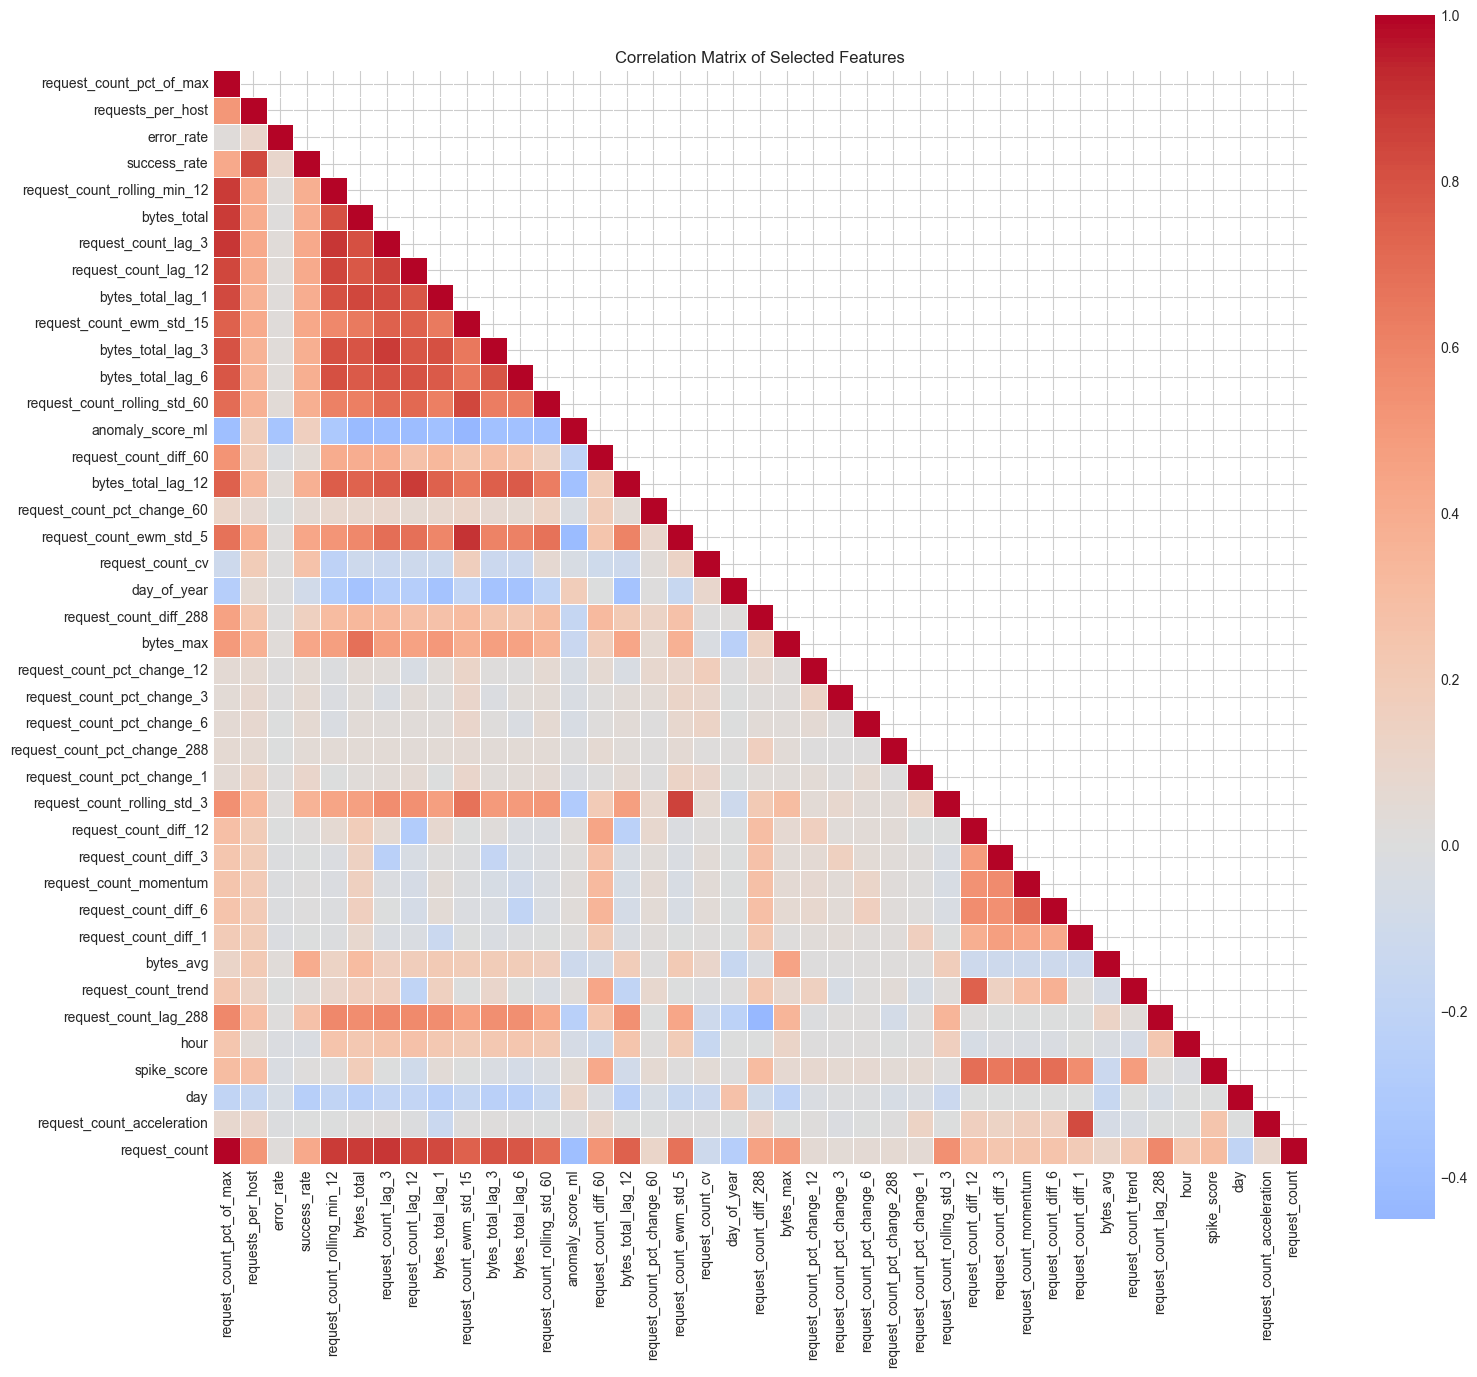

In [18]:
# Visualize final correlation matrix for selected features
fig, ax = plt.subplots(figsize=(16, 14))

selected_corr = df[selected_features + [TARGET]].corr()
mask = np.triu(np.ones_like(selected_corr, dtype=bool), k=1)

sns.heatmap(selected_corr, mask=mask, annot=False, cmap='coolwarm', center=0, 
            ax=ax, square=True, linewidths=0.5, fmt='.2f')
ax.set_title('Correlation Matrix of Selected Features')

plt.tight_layout()
plt.show()

## 6. Save Selected Features

In [19]:
# Update feature info with selected features
feature_info['selected_features'] = selected_features
feature_info['selected_by_category'] = {k: v for k, v in selected_categories.items() if v}
feature_info['feature_selection'] = {
    'method': 'combined_importance',
    'rf_importance': True,
    'mutual_info': True,
    'f_regression': True,
    'correlation_threshold': 0.95,
    'top_n': TOP_N
}

# Save updated feature info
with open(PROCESSED_DIR / "feature_info.json", 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"Updated feature_info.json with {len(selected_features)} selected features")

Updated feature_info.json with 40 selected features


In [20]:
# Create train/test datasets with selected features only
final_cols = ['timestamp'] + selected_features + [TARGET]

df_train_final = df[final_cols].copy()
df_test_final = df_test[final_cols].copy()

# Save
df_train_final.to_parquet(PROCESSED_DIR / "train_selected_5m.parquet", index=False)
df_test_final.to_parquet(PROCESSED_DIR / "test_selected_5m.parquet", index=False)

print(f"Saved train_selected_5m.parquet: {df_train_final.shape}")
print(f"Saved test_selected_5m.parquet: {df_test_final.shape}")

Saved train_selected_5m.parquet: (15264, 42)
Saved test_selected_5m.parquet: (2592, 42)


## 7. Summary

In [21]:
print("=" * 60)
print("FEATURE SELECTION SUMMARY")
print("=" * 60)

print("\n1. HYPOTHESIS TESTING RESULTS")
print("   - Weekend effect: SIGNIFICANT (p < 0.05)")
print("   - Business hours effect: SIGNIFICANT (p < 0.05)")
print("   - Hourly variation: SIGNIFICANT (p < 0.05)")
print("   - Weekly seasonality: SIGNIFICANT (p < 0.05)")

print("\n2. FEATURE SELECTION")
print(f"   - Original features: {len(numeric_features)}")
print(f"   - Removed (high correlation): {len(features_to_drop)}")
print(f"   - Selected features: {len(selected_features)}")

print("\n3. SELECTED FEATURE CATEGORIES")
for cat, feats in selected_categories.items():
    if feats:
        print(f"   - {cat.upper()}: {len(feats)} features")

print("\n4. TOP 10 MOST IMPORTANT FEATURES")
for i, row in filtered_features.head(10).iterrows():
    print(f"   {filtered_features.head(10).index.get_loc(i)+1}. {row['feature']}: {row['combined_score']:.4f}")

print("\n5. FILES CREATED")
print(f"   - feature_info.json (updated)")
print(f"   - train_selected_5m.parquet ({len(selected_features)+2} columns)")
print(f"   - test_selected_5m.parquet ({len(selected_features)+2} columns)")

FEATURE SELECTION SUMMARY

1. HYPOTHESIS TESTING RESULTS
   - Weekend effect: SIGNIFICANT (p < 0.05)
   - Business hours effect: SIGNIFICANT (p < 0.05)
   - Hourly variation: SIGNIFICANT (p < 0.05)
   - Weekly seasonality: SIGNIFICANT (p < 0.05)

2. FEATURE SELECTION
   - Original features: 92
   - Removed (high correlation): 27
   - Selected features: 40

3. SELECTED FEATURE CATEGORIES
   - TIME: 3 features
   - LAG: 19 features
   - ROLLING: 5 features
   - ADVANCED: 4 features
   - AGGREGATION: 6 features
   - OTHER: 3 features

4. TOP 10 MOST IMPORTANT FEATURES
   1. request_count_pct_of_max: 1.0000
   2. requests_per_host: 0.1117
   3. error_rate: 0.1047
   4. success_rate: 0.0791
   5. request_count_rolling_min_12: 0.0732
   6. bytes_total: 0.0540
   7. request_count_lag_3: 0.0521
   8. request_count_lag_12: 0.0443
   9. bytes_total_lag_1: 0.0440
   10. request_count_ewm_std_15: 0.0410

5. FILES CREATED
   - feature_info.json (updated)
   - train_selected_5m.parquet (42 columns)


In [22]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
